# Combining tides with satellite data

This guide demonstrates how to combine tide modelling with satellite Earth observation (EO) data using the [`tag_tides`](../../api/#eo_tides.eo.tag_tides) and [`pixel_tides`](../../api/#eo_tides.eo.pixel_tides) functions from [`eo_tides.eo`](../../api/#eo_tides.eo). 

Both these functions allow you to model the height of the tide at the exact moment of satellite image acquisition. 
This can then allow you to analyse satellite EO data by tidal conditions - for example, filter your data to satellite imagery collected during specific tidal stages (e.g. low or high tide).

Although both functions perform a similar function, they differ in complexity and performance. `tag_tides` assigns a single tide height to each timestep/satellite image, which is fast and efficient, and suitable for small-scale applications where tides are unlikely to vary across your study area. In constrast, `pixel_tide` models tides both through time *and* spatially, returning a tide height for every satellite pixel. This can be critical for producing seamless coastal EO datasets at large scale - however comes at the cost of performance.
<br><br>
**Comparison of `tag_tides` and `pixel_tides`**
| [`tag_tides`](../../api/#eo_tides.eo.tag_tides)                                                                 | [`pixel_tides`](../../api/#eo_tides.eo.pixel_tides)                                                                                              |
|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| Assigns a single tide height to each timestep/satellite image                         | Assigns a tide height to every individual pixel through time                                               |
| 🔎 Ideal for local or site-scale analysis                                      | 🌏 Ideal for regional to global-scale coastal product generation                                              |
| ✅ Fast, low memory use                                                        | ❌ Slower, higher memory use                                                                                  |
| ❌ Single tide height per image can produce artefacts in complex tidal regions | ✅ Produce spatially seamless results across large extents by applying analyses at the pixel level |

## Load satellite data using odc-stac

First, we will load a time-series of satellite data over our area of interest using the Open Data Cube's `odc-stac` package.
This powerful package allows us to load open satellite data (e.g ESA Sentinel-2 or NASA/USGS Landsat) for any time period and location on the planet, and load our data into a multi-dimensional `xarray.Dataset` format dataset.

In this example, we will load **Landsat 8 and 9** satellite data from **2024** over the city of **Broome, Western Australia** - a region with a macrotidal tide range and extensive intertidal coastal habitats.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed guide to using STAC metadata and <code>odc-stac</code> to find and load satellite data, refer to the <a href="https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/">Digital Earth Australia STAC user guide</a>.
    </p>
</div>

In [37]:
import odc.stac
import pystac_client

# Connect to STAC catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

# Set cloud defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query
bbox = [122.120, -18.25, 122.44, -17.93]
query = catalog.search(
    bbox=bbox,
    collections=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    datetime="2024-01-01/2024-12-31",
    filter = "eo:cloud_cover < 10"
)

# Search the STAC catalog for all items matching the query
ds = odc.stac.load(
    list(query.items()),
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

ds.isel(time=0).odc.explore(vmin=50, vmax=3000)

## Using tag_tides

We can pass our satellite dataset `ds` to the `tag_tides` function to model a tide for each timestep in our dataset.
This can help sort and filter images by tide height, allowing us to learn more about how coastal environments respond to the effect of changing tides.

The `tag_tides` function uses the time and date of acquisition and the geographic location of each satellite observation as inputs for the selected tide model (EOT20 by default).

In [38]:
from eo_tides.eo import tag_tides

ds = tag_tides(
    ds=ds,
    directory="../../tests/data/tide_models"
)

Setting tide modelling location from dataset centroid: 122.28, -18.09
Modelling tides using EOT20


Our output data now has a new `tide_height` variable under **Data variables**:

In [39]:
print(ds)

<xarray.Dataset> Size: 774MB
Dimensions:      (y: 1185, x: 1134, time: 48)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.408e+05 4.408e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 384B 2024-01-07T01:55:31.679580 ... 20...
    tide_model   <U5 20B 'EOT20'
Data variables:
    nbart_red    (time, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_green  (time, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    tide_height  (time) float32 192B -0.2511 0.5276 -1.814 ... 1.658 0.7031


We can plot this new `tide_height` variable to inspect the range of tide heights observed by the satellites in our time series:

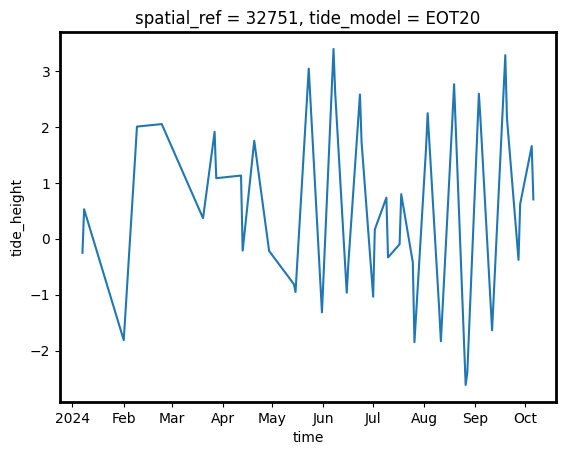

In [40]:
ds.tide_height.plot();

### Modelling ebb and flow tidal phases
The `tag_tides` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`. This is achieved by comparing tide heights 15 minutes before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

Once you run the cell below, our data will now also contain a new `ebb_flow` variable under **Data variables**:

In [41]:
# Model tide heights
ds = tag_tides(
    ds, 
    ebb_flow=True,     
    directory="../../tests/data/tide_models"
)

# Print output data
print(ds)

Setting tide modelling location from dataset centroid: 122.28, -18.09
Modelling tides using EOT20
Modelling tidal phase (e.g. ebb or flow)
Modelling tides using EOT20
<xarray.Dataset> Size: 774MB
Dimensions:      (y: 1185, x: 1134, time: 48)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.408e+05 4.408e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 384B 2024-01-07T01:55:31.679580 ... 20...
    tide_model   <U5 20B 'EOT20'
Data variables:
    nbart_red    (time, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_green  (time, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    tide_height  (time) float32 192B -0.2511 0.5276 -1.814 ... 1.658 0.7031
    ebb_flow     (time) object 384B 'Ebb' 'Ebb' 'Flow' .

We now have data giving us the both the tide height and tidal phase ("ebb" or "flow") for every satellite image:

In [42]:
ds[["time", "tide_height", "ebb_flow"]].drop("spatial_ref").to_dataframe().head()

,tide_height,ebb_flow,tide_model
time,,,
2024-01-07 01:55:31.679580,-0.251089,Ebb,EOT20
2024-01-08 01:49:36.716728,0.527567,Ebb,EOT20
2024-02-01 01:49:24.643430,-1.813516,Flow,EOT20
2024-02-08 01:56:00.413098,1.517171,Flow,EOT20
2024-02-09 01:49:13.176170,2.006911,Flow,EOT20


We could for example use this data to filter our observations to keep ebbing phase observations only:

In [43]:
ds_ebb = ds.where(ds.ebb_flow == "Ebb", drop=True)
print(ds_ebb)

<xarray.Dataset> Size: 210MB
Dimensions:      (time: 13, y: 1185, x: 1134)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.408e+05 4.408e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 104B 2024-01-07T01:55:31.679580 ... 20...
    tide_model   <U5 20B 'EOT20'
Data variables:
    nbart_red    (time, y, x) float32 70MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_green  (time, y, x) float32 70MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 70MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    tide_height  (time) float32 52B -0.2511 0.5276 1.753 ... -0.3772 0.6212
    ebb_flow     (time) object 104B 'Ebb' 'Ebb' 'Ebb' ... 'Ebb' 'Ebb' 'Ebb'


### Swapping dimensions
The `tag_tides` function allows you to use tide height as the primary dimension in the dataset, instead of time. Setting `swap_dims=True` will swap the time dimension in the original `xarray.Dataset` to the new `tide_height` variable.

This will produce a dataset containing three **dimensions**: `y`, `x` and `tide_height`.

In [44]:
# Model tide heights
ds_swapped = tag_tides(
    ds, 
    swap_dims=True,     
    directory="../../tests/data/tide_models"
)

# Print output data
print(ds_swapped)

Setting tide modelling location from dataset centroid: 122.28, -18.09


Modelling tides using EOT20
<xarray.Dataset> Size: 774MB
Dimensions:      (y: 1185, x: 1134, tide_height: 48)
Coordinates:
  * y            (y) float64 9kB 8.017e+06 8.017e+06 ... 7.982e+06 7.982e+06
  * x            (x) float64 9kB 4.068e+05 4.068e+05 ... 4.408e+05 4.408e+05
    spatial_ref  int32 4B 32751
    tide_model   <U5 20B 'EOT20'
  * tide_height  (tide_height) float32 192B -2.615 -2.399 -1.85 ... 3.285 3.396
Data variables:
    nbart_red    (tide_height, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_green  (tide_height, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    nbart_blue   (tide_height, y, x) float32 258MB dask.array<chunksize=(1, 1185, 1134), meta=np.ndarray>
    ebb_flow     (tide_height) object 384B 'Flow' 'Flow' ... 'Flow' 'Flow'


Using tide height as a dimension can make it easier to analyse the data with respect to tide, e.g. plotting the lowest and highest tide image in our dataset:

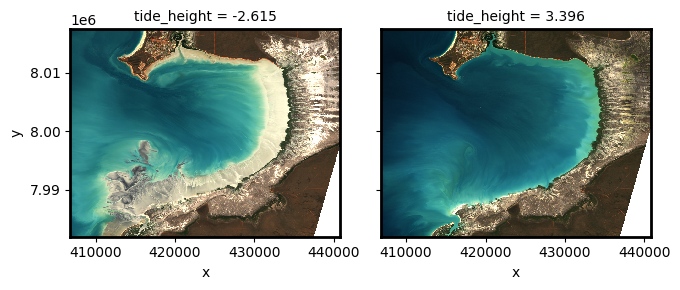

In [45]:
ds_swapped.isel(tide_height=[0, -1]).odc.to_rgba(vmin=50, vmax=3000).plot.imshow(col="tide_height")

## Using pixel_tides



In [46]:
from eo_tides.eo import pixel_tides

tides_highres, tides_lowres = pixel_tides(
    ds=ds,
    model="EOT20",
    directory="../../tests/data/tide_models"
)

tides_highres.isel(time=0).odc.explore()

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using EOT20 in parallel


100%|██████████| 5/5 [00:00<00:00, 11.00it/s]


Reprojecting tides into original array


## Next steps

Now that we have learnt to combine tide modelling with satellite data, we can learn how to [calculate statistics](../Tide_statistics) describing local tide dynamics, as well as biases caused by interactions between tidal processes and satellite orbits.